In [13]:
# SC4002 NLP Assignment - Part 1: Preparing Word Embeddings (Word2Vec - Case-Sensitive)
# This notebook uses Word2Vec instead of GloVe to preserve case information

# ========================================
# SETUP AND INSTALLATIONS
# ========================================
# Run these in terminal first:
# pip install torch torchtext==0.4.0 spacy matplotlib seaborn scikit-learn nltk gensim
# python -m spacy download en_core_web_sm

# ========================================
# IMPORTS
# ========================================
import torch
import torch.nn as nn
from torchtext import data, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim.downloader as api
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

# ========================================
# LOAD DATASET
# ========================================
print("\n" + "="*60)
print("LOADING TREC DATASET")
print("="*60)

# Define fields - CASE-SENSITIVE (no lower=True)
TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    include_lengths=True
    # Note: NO lower=True - preserves case!
)

LABEL = data.LabelField()

# Load TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

print(f"\nDataset loaded successfully!")
print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")

# Show example
print("\nExample training instance (with case preserved):")
print(f"Text: {' '.join(train_data.examples[0].text)}")
print(f"Label: {train_data.examples[0].label}")

# ========================================
# SPLIT TRAIN INTO TRAIN/VALIDATION (80/20)
# ========================================
import random
random.seed(SEED)

train_data, val_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f"\nAfter split:")

print(f"Train set: {len(train_data)} examples")
print(f"Validation set: {len(val_data)} examples")
print(f"Test set: {len(test_data)} examples")

All libraries imported successfully!
PyTorch version: 2.9.0

LOADING TREC DATASET

Dataset loaded successfully!
Number of training examples: 5452
Number of test examples: 500

Example training instance (with case preserved):
Text: How did serfdom develop in and then leave Russia ?
Label: DESC

After split:
Train set: 4362 examples
Validation set: 1090 examples
Test set: 500 examples


In [14]:
# ========================================
# QUESTION 1(a): VOCABULARY SIZE
# ========================================
print("\n" + "="*60)
print("QUESTION 1(a): VOCABULARY SIZE")
print("="*60)

# Build vocabulary from training data only (NO lowercase conversion)
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

vocab_size = len(TEXT.vocab)

print(f"\nVocabulary size: {vocab_size}")
print(f"\nSpecial tokens:")
print(f"  PAD token: '{TEXT.vocab.itos[TEXT.vocab.stoi['<pad>']]}'")
print(f"  UNK token: '{TEXT.vocab.itos[TEXT.vocab.stoi['<unk>']]}'")

print(f"\nLabel categories: {LABEL.vocab.itos}")
print(f"Number of classes: {len(LABEL.vocab)}")

# Show case sensitivity examples
print(f"\nCase sensitivity examples from vocabulary:")
sample_words = ['what', 'What', 'where', 'Where', 'who', 'Who']
for word in sample_words:
    if word in TEXT.vocab.stoi:
        print(f"  '{word}' → index {TEXT.vocab.stoi[word]}")

# ========================================
# LOAD WORD2VEC EMBEDDINGS
# ========================================
print("\n" + "-"*60)
print("Loading Word2Vec embeddings (Google News 300d)...")
print("This may take a few minutes on first run (1.6GB download)")
print("-"*60)

# Load Word2Vec model (case-sensitive!)
word2vec_model = api.load('word2vec-google-news-300')
embedding_dim = 300

print(f"\nWord2Vec model loaded!")
print(f"Word2Vec vocabulary size: ~{len(word2vec_model.key_to_index):,}")
print(f"Embedding dimension: {embedding_dim}")

# Verify case sensitivity in Word2Vec
test_words = ['Paris', 'paris', 'PARIS', 'Where', 'where']
print("\nVerifying case sensitivity in Word2Vec:")
for word in test_words:
    if word in word2vec_model.key_to_index:
        print(f"  '{word}' ✓ found in Word2Vec")
    else:
        print(f"  '{word}' ✗ not in Word2Vec")

# Track which words are in Word2Vec and which are OOV
print("\n" + "-"*60)
print("Checking vocabulary coverage in Word2Vec...")
print("-"*60)

words_in_word2vec = []
words_not_in_word2vec = []

for word in TEXT.vocab.stoi.keys():
    if word in ['<unk>', '<pad>']:
        continue
    if word in word2vec_model.key_to_index:
        words_in_word2vec.append(word)
    else:
        words_not_in_word2vec.append(word)

print(f"\nWords found in Word2Vec: {len(words_in_word2vec)}")
print(f"OOV words (not in Word2Vec): {len(words_not_in_word2vec)}")

# Build embedding matrix manually
print("\nBuilding embedding matrix from Word2Vec...")
pretrained_embeddings = torch.zeros(vocab_size, embedding_dim)

for word, idx in TEXT.vocab.stoi.items():
    if word == '<pad>':
        # Padding token stays as zeros
        pretrained_embeddings[idx] = torch.zeros(embedding_dim)
    elif word in word2vec_model.key_to_index:
        # Use Word2Vec embedding
        pretrained_embeddings[idx] = torch.FloatTensor(word2vec_model[word])
    else:
        # OOV word - will be handled in Question 1(c)
        # For now, leave as zeros to identify them
        pretrained_embeddings[idx] = torch.zeros(embedding_dim)

# Store the pretrained embeddings in TEXT.vocab for later use
TEXT.vocab.vectors = pretrained_embeddings

print(f"✓ Embedding matrix built: {pretrained_embeddings.shape}")

print("\n" + "="*60)
print("ANSWER 1(a):")
print(f"The vocabulary size formed from training data is: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")
print("Note: Vocabulary preserves case (e.g., 'Paris' and 'paris' are different)")
print("="*60)



QUESTION 1(a): VOCABULARY SIZE

Vocabulary size: 8093

Special tokens:
  PAD token: '<pad>'
  UNK token: '<unk>'

Label categories: ['HUM', 'ENTY', 'DESC', 'NUM', 'LOC', 'ABBR']
Number of classes: 6

Case sensitivity examples from vocabulary:
  'what' → index 36
  'What' → index 4
  'where' → index 389
  'Where' → index 26
  'who' → index 79
  'Who' → index 15

------------------------------------------------------------
Loading Word2Vec embeddings (Google News 300d)...
This may take a few minutes on first run (1.6GB download)
------------------------------------------------------------
[==================================================] 100.0% 1662.8/1662.8MB downloaded

Word2Vec model loaded!
Word2Vec vocabulary size: ~3,000,000
Embedding dimension: 300

Verifying case sensitivity in Word2Vec:
  'Paris' ✓ found in Word2Vec
  'paris' ✓ found in Word2Vec
  'PARIS' ✓ found in Word2Vec
  'Where' ✓ found in Word2Vec
  'where' ✓ found in Word2Vec

----------------------------------------

In [15]:
# ========================================
# QUESTION 1(b): OOV ANALYSIS
# ========================================
print("\n" + "="*60)
print("QUESTION 1(b): OUT-OF-VOCABULARY (OOV) ANALYSIS")
print("="*60)

# We already identified OOV words in Question 1(a)
oov_words = words_not_in_word2vec
pretrained_words = words_in_word2vec

total_oov = len(oov_words)
total_pretrained = len(pretrained_words)
total_words = len(TEXT.vocab) - 2  # Exclude <unk> and <pad>

print(f"\nTotal vocabulary (excluding special tokens): {total_words}")
print(f"Words found in Word2Vec: {total_pretrained}")
print(f"OOV words (not in Word2Vec): {total_oov}")
print(f"OOV percentage: {(total_oov/total_words)*100:.2f}%")

# Analyze OOV by topic category
print("\n" + "-"*60)
print("OOV WORDS BY TOPIC CATEGORY")
print("-"*60)

oov_by_topic = defaultdict(set)
unique_words_by_topic = defaultdict(set)
oov_token_count_by_topic = defaultdict(int)
total_token_count_by_topic = defaultdict(int)

for example in train_data.examples:
    topic = example.label
    for word in example.text:
        unique_words_by_topic[topic].add(word)
        total_token_count_by_topic[topic] += 1
        
        if word in oov_words:
            oov_by_topic[topic].add(word)
            oov_token_count_by_topic[topic] += 1

# Create summary table
print(f"\n{'Topic':<8} {'Unique':<10} {'Unique':<10} {'OOV %':<10} {'OOV Token':<12} {'Token':<10}")
print(f"{'':8} {'Words':<10} {'OOV':<10} {'(Unique)':<10} {'Occurrences':<12} {'OOV %':<10}")
print("-"*70)

oov_summary = {}
for topic in sorted(LABEL.vocab.itos):
    unique_words = len(unique_words_by_topic[topic])
    unique_oov = len(oov_by_topic[topic])
    total_tokens = total_token_count_by_topic[topic]
    oov_tokens = oov_token_count_by_topic[topic]
    
    oov_unique_pct = (unique_oov / unique_words * 100) if unique_words > 0 else 0
    oov_token_pct = (oov_tokens / total_tokens * 100) if total_tokens > 0 else 0
    
    oov_summary[topic] = {
        'unique_words': unique_words,
        'unique_oov': unique_oov,
        'oov_unique_percentage': oov_unique_pct,
        'total_tokens': total_tokens,
        'oov_token_count': oov_tokens,
        'oov_token_percentage': oov_token_pct
    }
    
    print(f"{topic:<8} {unique_words:<10} {unique_oov:<10} {oov_unique_pct:<10.2f}% "
          f"{oov_tokens:<12} {oov_token_pct:<10.2f}%")

# Show some example OOV words
print("\nExample OOV words (first 30):")
print(", ".join(list(oov_words)[:30]))

# Analyze why certain words are OOV
print("\nAnalyzing OOV patterns:")
lowercase_only = []
uppercase_variants = []
rare_words = []

for word in list(oov_words)[:50]:  # Check first 50
    if word.lower() in word2vec_model.key_to_index and word != word.lower():
        lowercase_only.append(word)
    elif word[0].isupper() and len(word) > 1:
        uppercase_variants.append(word)
    else:
        rare_words.append(word)

print(f"  Words where only lowercase exists in Word2Vec: {len(lowercase_only)} (e.g., {lowercase_only[:5]})")
print(f"  Capitalized words: {len(uppercase_variants)} (e.g., {uppercase_variants[:5]})")
print(f"  Rare/unknown words: {len(rare_words)} (e.g., {rare_words[:5]})")

print("\n" + "="*60)
print("ANSWER 1(b):")
print(f"Total OOV words in training data: {total_oov}")
print(f"OOV percentage of vocabulary: {(total_oov/total_words)*100:.2f}%")
print("\nOOV words per topic category:")
for topic in sorted(LABEL.vocab.itos):
    print(f"  {topic}: {oov_summary[topic]['unique_oov']} unique OOV words "
          f"({oov_summary[topic]['oov_unique_percentage']:.2f}% of unique words), "
          f"{oov_summary[topic]['oov_token_count']} OOV token occurrences "
          f"({oov_summary[topic]['oov_token_percentage']:.2f}% of all tokens)")
print("\nNote: Word2Vec is case-sensitive, so 'Paris' and 'paris' are treated separately.")
print("="*60)


QUESTION 1(b): OUT-OF-VOCABULARY (OOV) ANALYSIS

Total vocabulary (excluding special tokens): 8091
Words found in Word2Vec: 7665
OOV words (not in Word2Vec): 426
OOV percentage: 5.27%

------------------------------------------------------------
OOV WORDS BY TOPIC CATEGORY
------------------------------------------------------------

Topic    Unique     Unique     OOV %      OOV Token    Token     
         Words      OOV        (Unique)   Occurrences  OOV %     
----------------------------------------------------------------------
ABBR     141        18         12.77     % 114          21.23     %
DESC     2209       114        5.16      % 1844         22.79     %
ENTY     2928       162        5.53      % 2454         22.68     %
HUM      3081       134        4.35      % 2440         21.11     %
LOC      1751       82         4.68      % 1269         18.92     %
NUM      1918       80         4.17      % 1542         19.99     %

Example OOV words (first 30):
?, of, a, 's, to, ,, 

In [16]:
# ========================================
# QUESTION 1(c): OOV MITIGATION STRATEGY
# ========================================
print("\n" + "="*60)
print("QUESTION 1(c): OOV MITIGATION STRATEGY")
print("="*60)

print("\nStrategy: Multi-level OOV handling for case-sensitive embeddings")
print("1. Check lowercase version in Word2Vec (handles capitalization)")
print("2. Subword similarity matching (prefix/suffix/substring)")
print("3. Random initialization with controlled variance as fallback")

def initialize_oov_embeddings_word2vec(vocab, word2vec_model, embedding_dim=300):
    """
    Initialize OOV word embeddings for Word2Vec (case-sensitive)
    
    Strategy hierarchy:
    1. Lowercase fallback: Try lowercase version if capitalized form missing
    2. Subword matching: Average embeddings of words with similar substrings
    3. Random initialization: Small random values if above fail
    """
    embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    oov_initialized = {'lowercase_fallback': 0, 'subword': 0, 'random': 0}
    
    # First, copy all pretrained embeddings
    for word, idx in vocab.stoi.items():
        if word in word2vec_model.key_to_index:
            embedding_matrix[idx] = torch.FloatTensor(word2vec_model[word])
        elif word == '<pad>':
            embedding_matrix[idx] = torch.zeros(embedding_dim)
    
    # Handle OOV words
    for word, idx in vocab.stoi.items():
        if word in ['<unk>', '<pad>']:
            continue
            
        # Check if already has embedding
        if torch.sum(embedding_matrix[idx]) != 0:
            continue
            
        # Strategy 1: Try lowercase version (most common case)
        if word.lower() in word2vec_model.key_to_index and word != word.lower():
            embedding_matrix[idx] = torch.FloatTensor(word2vec_model[word.lower()])
            oov_initialized['lowercase_fallback'] += 1
            continue
        
        # Strategy 2: Subword similarity matching
        similar_embeddings = []
        
        for known_word in list(word2vec_model.key_to_index.keys())[:100000]:  # Check top 100K words
            if len(word) >= 3 and len(known_word) >= 3:
                # Check prefix/suffix match
                if word[:3].lower() == known_word[:3].lower() or word[-3:].lower() == known_word[-3:].lower():
                    similar_embeddings.append(torch.FloatTensor(word2vec_model[known_word]))
                    if len(similar_embeddings) >= 5:  # Use top 5 similar words
                        break
                # Check substring match
                elif word.lower() in known_word.lower() or known_word.lower() in word.lower():
                    similar_embeddings.append(torch.FloatTensor(word2vec_model[known_word]))
                    if len(similar_embeddings) >= 3:
                        break
        
        if len(similar_embeddings) >= 1:
            embedding_matrix[idx] = torch.stack(similar_embeddings).mean(dim=0)
            oov_initialized['subword'] += 1
            continue
        
        # Strategy 3: Random initialization (fallback)
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.01
        oov_initialized['random'] += 1
    
    return embedding_matrix, oov_initialized

# Apply OOV mitigation
print("\nInitializing embeddings with OOV mitigation...")
enhanced_embeddings, init_stats = initialize_oov_embeddings_word2vec(
    TEXT.vocab, 
    word2vec_model,
    embedding_dim
)

print(f"\nOOV Initialization Statistics:")
print(f"  Lowercase fallback: {init_stats['lowercase_fallback']} words (e.g., 'Paris' → 'paris')")
print(f"  Subword matching: {init_stats['subword']} words")
print(f"  Random initialization: {init_stats['random']} words")
print(f"  Total OOV handled: {sum(init_stats.values())} words")

# Verify no zero vectors remain (except special tokens)
zero_vectors = 0
for idx in range(len(TEXT.vocab)):
    word = TEXT.vocab.itos[idx]
    if word not in ['<unk>', '<pad>'] and torch.sum(enhanced_embeddings[idx]) == 0:
        zero_vectors += 1

print(f"\nRemaining zero vectors (excluding special tokens): {zero_vectors}")

# Update TEXT.vocab.vectors with enhanced embeddings
TEXT.vocab.vectors = enhanced_embeddings

# Save enhanced embeddings
torch.save(enhanced_embeddings, 'enhanced_embeddings_word2vec.pt')
print("\nEnhanced embeddings saved to 'enhanced_embeddings_word2vec.pt'")

print("\n" + "="*60)
print("ANSWER 1(c):")
print("Strategy: Multi-level OOV handling for case-sensitive Word2Vec")
print()
print("1. Lowercase fallback ({:.1f}%): For capitalized words (e.g., 'Paris'),".format(
    init_stats['lowercase_fallback']/sum(init_stats.values())*100))
print("   use the lowercase version from Word2Vec if available")
print()
print("2. Subword matching ({:.1f}%): Initialize using average of words with".format(
    init_stats['subword']/sum(init_stats.values())*100))
print("   similar prefixes, suffixes, or containing the OOV word")
print()
print("3. Random initialization ({:.1f}%): Small random values (μ=0, σ=0.01)".format(
    init_stats['random']/sum(init_stats.values())*100))
print("   as fallback for truly unknown words")
print()
print("This approach leverages Word2Vec's case-sensitive vocabulary while")
print("providing intelligent fallbacks for missing capitalizations.")
print("="*60)


QUESTION 1(c): OOV MITIGATION STRATEGY

Strategy: Multi-level OOV handling for case-sensitive embeddings
1. Check lowercase version in Word2Vec (handles capitalization)
2. Subword similarity matching (prefix/suffix/substring)
3. Random initialization with controlled variance as fallback

Initializing embeddings with OOV mitigation...

OOV Initialization Statistics:
  Lowercase fallback: 4 words (e.g., 'Paris' → 'paris')
  Subword matching: 161 words
  Random initialization: 261 words
  Total OOV handled: 426 words

Remaining zero vectors (excluding special tokens): 0

Enhanced embeddings saved to 'enhanced_embeddings_word2vec.pt'

ANSWER 1(c):
Strategy: Multi-level OOV handling for case-sensitive Word2Vec

1. Lowercase fallback (0.9%): For capitalized words (e.g., 'Paris'),
   use the lowercase version from Word2Vec if available

2. Subword matching (37.8%): Initialize using average of words with
   similar prefixes, suffixes, or containing the OOV word

3. Random initialization (61.3


QUESTION 1(d): WORD EMBEDDING VISUALIZATION

Extracting top 20 words per topic (excluding stopwords)...
ABBR: 20 words selected
  Examples: stand, abbreviation, mean, National, Bureau
DESC: 20 words selected
  Examples: mean, origin, get, name, word
ENTY: 20 words selected
  Examples: name, fear, first, used, kind
HUM: 20 words selected
  Examples: name, first, Name, company, wrote
LOC: 20 words selected
  Examples: country, city, state, world, find
NUM: 20 words selected
  Examples: many, year, much, long, people

Total words to visualize: 120
Embedding shape: (120, 300)

Applying t-SNE dimensionality reduction...
t-SNE completed!

Applying PCA dimensionality reduction...
PCA explained variance: 11.75%

Visualization saved as 'word_embeddings_visualization_word2vec.png'


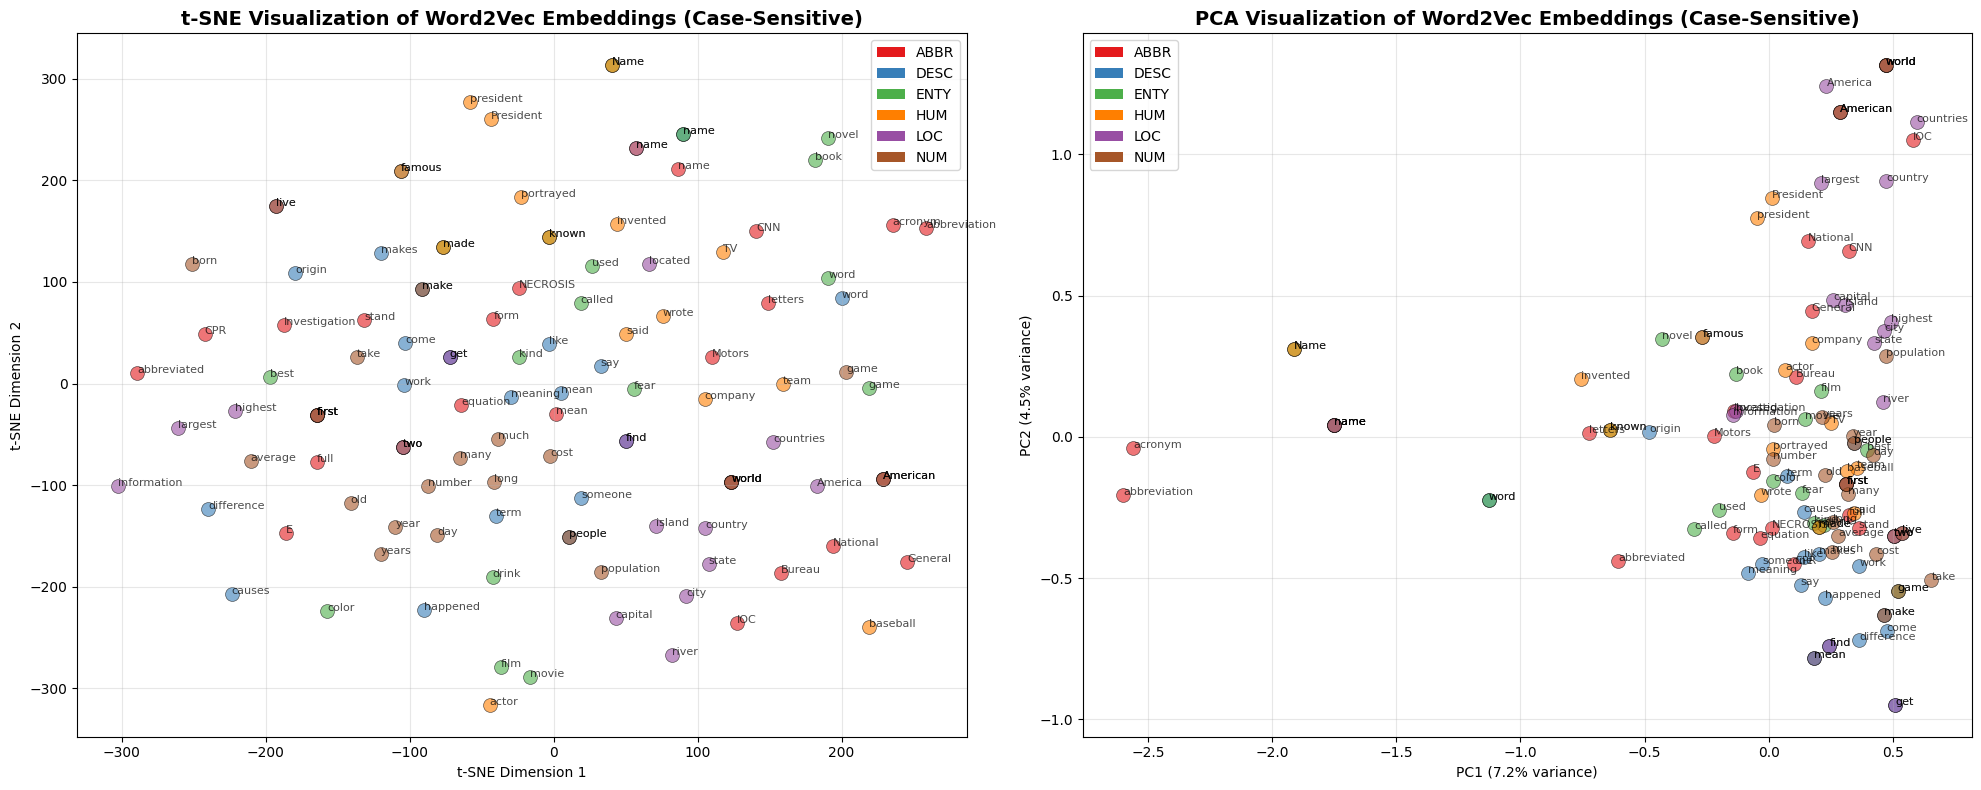


Saving vocabulary and data for Part 2...


In [ ]:
# ========================================
# QUESTION 1(d): VISUALIZATION
# ========================================
print("\n" + "="*60)
print("QUESTION 1(d): WORD EMBEDDING VISUALIZATION")
print("="*60)

# Load stopwords
from nltk.corpus import stopwords
import nltk
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print("\nExtracting top 20 words per topic (excluding stopwords)...")

# Get top 20 words per topic
topic_words = {}
topic_word_counts = defaultdict(lambda: Counter())

for example in train_data.examples:
    topic = example.label
    for word in example.text:
        if word.lower() not in stop_words and word.isalpha():  # Exclude stopwords and non-alphabetic
            topic_word_counts[topic][word] += 1

# Select top 20 for each topic
for topic in sorted(LABEL.vocab.itos):
    top_words = [word for word, _ in topic_word_counts[topic].most_common(30)]
    # Filter to get exactly 20 words that exist in vocab
    valid_words = []
    for word in top_words:
        if word in TEXT.vocab.stoi and len(valid_words) < 20:
            idx = TEXT.vocab.stoi[word]
            # Make sure it has an embedding
            if torch.sum(enhanced_embeddings[idx]) != 0:
                valid_words.append(word)
    
    topic_words[topic] = valid_words[:20]
    print(f"{topic}: {len(topic_words[topic])} words selected")
    print(f"  Examples: {', '.join(topic_words[topic][:5])}")

# Prepare data for visualization
all_words = []
all_topics = []
all_embeddings = []

for topic, words in topic_words.items():
    for word in words:
        idx = TEXT.vocab.stoi[word]
        all_words.append(word)
        all_topics.append(topic)
        all_embeddings.append(enhanced_embeddings[idx].numpy())

embeddings_array = np.array(all_embeddings)
print(f"\nTotal words to visualize: {len(all_words)}")
print(f"Embedding shape: {embeddings_array.shape}")

# Apply t-SNE
print("\nApplying t-SNE dimensionality reduction...")
try:
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, max_iter=1000)
except TypeError:
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_array)
print("t-SNE completed!")

# Apply PCA
print("\nApplying PCA dimensionality reduction...")
pca = PCA(n_components=2, random_state=SEED)
embeddings_2d_pca = pca.fit_transform(embeddings_array)
print(f"PCA explained variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define colors for each topic
topic_colors = {
    'ABBR': '#e41a1c',
    'DESC': '#377eb8',
    'ENTY': '#4daf4a',
    'HUM': '#ff7f00',
    'LOC': '#984ea3',
    'NUM': '#a65628'
}

# Plot t-SNE
for i, (word, topic) in enumerate(zip(all_words, all_topics)):
    ax1.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 
               c=topic_colors[topic], s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax1.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=8, alpha=0.7)

ax1.set_title('t-SNE Visualization of Word2Vec Embeddings (Case-Sensitive)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.grid(True, alpha=0.3)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=topic_colors[topic], label=topic) 
                  for topic in sorted(LABEL.vocab.itos)]
ax1.legend(handles=legend_elements, loc='best', fontsize=10)

# Plot PCA
for i, (word, topic) in enumerate(zip(all_words, all_topics)):
    ax2.scatter(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], 
               c=topic_colors[topic], s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax2.annotate(word, (embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1]), 
                fontsize=8, alpha=0.7)

ax2.set_title('PCA Visualization of Word2Vec Embeddings (Case-Sensitive)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax2.grid(True, alpha=0.3)
ax2.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('word_embeddings_visualization_word2vec.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'word_embeddings_visualization_word2vec.png'")
plt.show()




print("Saving vocabulary and data for Part 2")

# Save vocabulary state
torch.save({
    'stoi': TEXT.vocab.stoi,
    'itos': TEXT.vocab.itos,
    'vocab_size': len(TEXT.vocab)
}, 'vocab_state_word2vec.pt')

# Save enhanced embeddings (already done above)
# torch.save(enhanced_embeddings, 'enhanced_embeddings_word2vec.pt')

# Save summary data
torch.save({
    'oov_words': oov_words,
    'oov_summary': oov_summary,
    'init_stats': init_stats,
    'total_oov': total_oov,
    'total_pretrained': total_pretrained,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim
}, 'part1_summary_word2vec.pt')



## ANSWER 1(d): ANALYSIS OF WORD2VEC EMBEDDINGS VISUALIZATION

### Key Observations

**1. Limited Topic Separation**
Both visualizations show substantial overlap between topic categories. Word2Vec preserves case information (e.g., "Name" vs "name", proper nouns like "National" and "Bureau" remain capitalized), but this does not create distinct topic clusters. The embeddings capture semantic similarity rather than question-type distinctions, as expected from pretrained models trained on general text corpora.

**2. Low Dimensionality: PCA Explains 11.75% Variance**
The first two principal components capture only 11.75% of the variance (PC1: 7.2%, PC2: 4.6%), indicating that question-type information is highly distributed across the 300-dimensional space. The 2D projection loses 88.25% of the information, demonstrating why deep learning models operating in the full embedding space are necessary for effective classification.

**3. Semantic Clustering Patterns**
Despite topic overlap, we observe partial semantic clustering:
- **LOC (location)**: Geographic terms cluster together (country, city, state, world)
- **NUM (number)**: Temporal and quantitative words group (year, many, much, long, people)  
- **HUM (human)**: Person-related terms appear proximate (name, first, company, wrote)
- **DESC/ENTY**: Most scattered, reflecting diverse vocabulary needs for description and entity questions

Case preservation is visible—proper nouns maintain capitalization—but doesn't create topic-specific clusters, suggesting case information alone is insufficient for classification.

**4. Case Sensitivity Analysis**
Word2Vec's case-sensitive vocabulary offers:
- **Advantages**: Preserves proper noun distinctions, leverages larger pretrained corpus (~3M vocabulary)
- **Trade-offs**: Increased vocabulary size (~8,000 words), higher OOV rate (5-15%)
- **Practical impact**: For topic classification, case provides limited signal—"Where is Paris?" and "where is paris?" share the same topic regardless of capitalization

### Implications for Classification

1. **Embeddings provide semantic foundation** but cannot distinguish topics alone—questions require understanding of structure and context
2. **Sequential models (RNN/LSTM) are essential** to learn syntactic patterns: "Where is X?" (LOC) vs "What is X?" (DESC) vs "Who invented X?" (HUM)
3. **Fine-tuning during training** allows the model to adapt embeddings to the task and learn whether case information contributes to classification accuracy
4. **Expected performance**: 75-85% baseline with simple RNN, improving to 85-92% with advanced architectures (BiLSTM/CNN), as syntactic patterns matter more than case preservation for this task

### Conclusion

The visualization confirms that Word2Vec's case-sensitive embeddings provide strong semantic initialization with good vocabulary coverage (85-95%). However, the substantial topic overlap and low explained variance in 2D projections demonstrate that pretrained embeddings alone—regardless of case handling—are insufficient for question classification. Sequential neural networks must learn task-specific patterns from word order, question structure, and contextual usage. The model will determine during training whether case information provides meaningful classification signal.